In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Load the dataset (Make sure the CSV is uploaded to the Kaggle environment)
df = pd.read_csv('/kaggle/input/forcasting/updated_forecasting_data_2005_2023.csv')

# Check the data
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   50000 non-null  int64  
 1   transaction_date     50000 non-null  object 
 2   product_id           50000 non-null  int64  
 3   product_name         50000 non-null  object 
 4   total_quantity_sold  50000 non-null  int64  
 5   total_sales          50000 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.3+ MB


In [3]:
# Convert the 'transaction_date' column to datetime format
df['transaction_date'] = pd.to_datetime(df['transaction_date'])


In [4]:
# Aggregate data by transaction date for total sales and total quantity sold
daily_sales = df.groupby('transaction_date').agg({
    'total_sales': 'sum',
    'total_quantity_sold': 'sum'
}).reset_index()


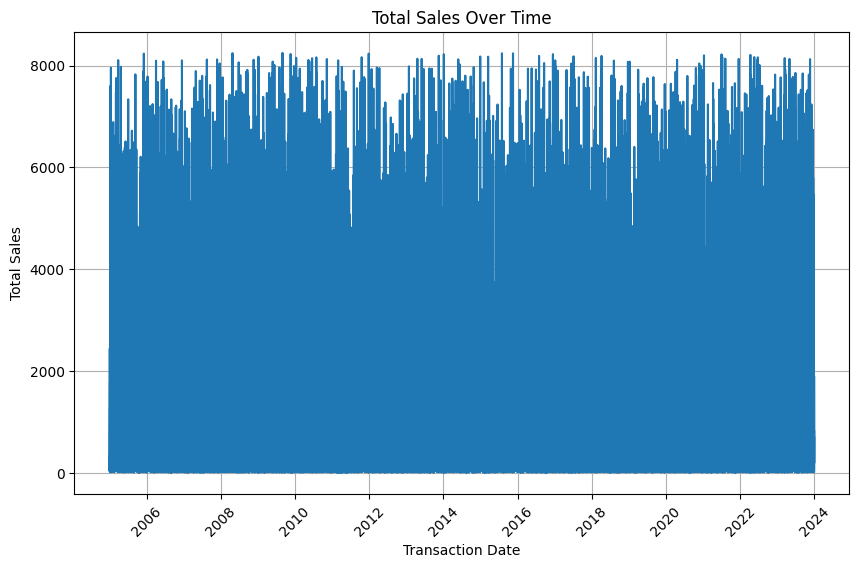

In [5]:
# Plot the time series of total sales over time
plt.figure(figsize=(10, 6))
plt.plot(daily_sales['transaction_date'], daily_sales['total_sales'], label='Total Sales')
plt.title('Total Sales Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

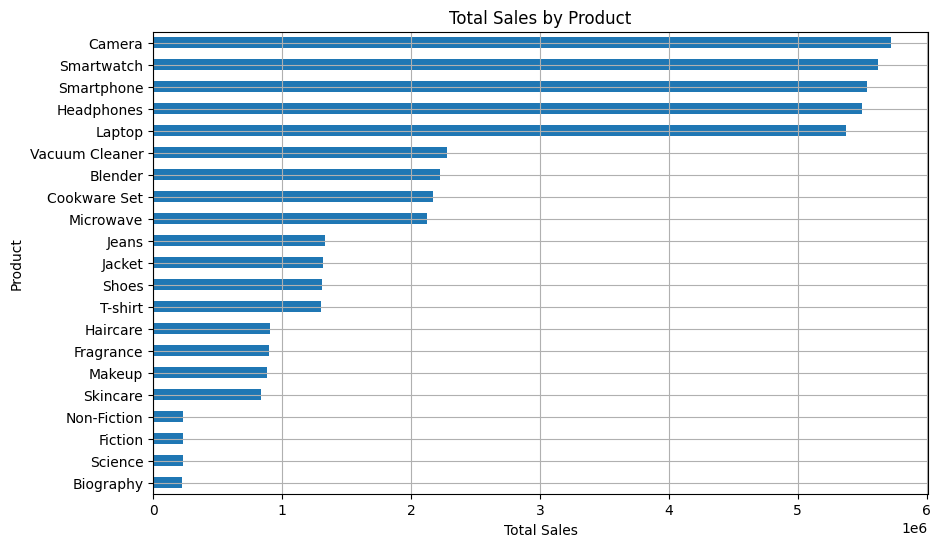

In [6]:
# Plot the distribution of total sales by product
plt.figure(figsize=(10, 6))
df.groupby('product_name')['total_sales'].sum().sort_values().plot(kind='barh')
plt.title('Total Sales by Product')
plt.xlabel('Total Sales')
plt.ylabel('Product')
plt.grid(True)
plt.show()


In [7]:
# Plot the distribution of total quantity sold by product
plt.figure(figsize=(10, 6))
df.groupby('product_name')['total_quantity_sold'].sum().sort_values().plot(kind='barh', color='orange')
plt.title('Total Quantity Sold by Product')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.grid(True)
plt.show()


In [8]:
# Aggregating total sales over time for forecasting
sales_by_date = df.groupby(df['transaction_date'].dt.date)['total_sales'].sum().reset_index()
sales_by_date.columns = ['date', 'total_sales']
sales_by_date.set_index('date', inplace=True)
sales_by_date = sales_by_date.asfreq('D', fill_value=0)  # Fill missing dates with 0 sales


In [9]:

# Grouping by month
monthly_sales = df.resample('M', on='transaction_date').sum()['total_sales']


/tmp/ipykernel_17/3942200303.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M', on='transaction_date').sum()['total_sales']


In [10]:
# Display first few rows of monthly sales data
monthly_sales.head()

transaction_date
2005-01-31    223897.45
2005-02-28    173756.84
2005-03-31    230754.56
2005-04-30    178956.96
2005-05-31    182359.20
Freq: ME, Name: total_sales, dtype: float64

In [11]:
# Fit the ARIMA model on monthly sales data
model = ARIMA(monthly_sales, order=(5, 1, 0))  # ARIMA(5,1,0)
model_fit = model.fit()

In [12]:
# Forecast for the next 12 months
forecast_12_months = model_fit.forecast(steps=12)


In [13]:
# Create a date range for the forecasted 12 months
forecast_12_months_dates = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(1), periods=12, freq='M')


/tmp/ipykernel_17/3572500928.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_12_months_dates = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(1), periods=12, freq='M')


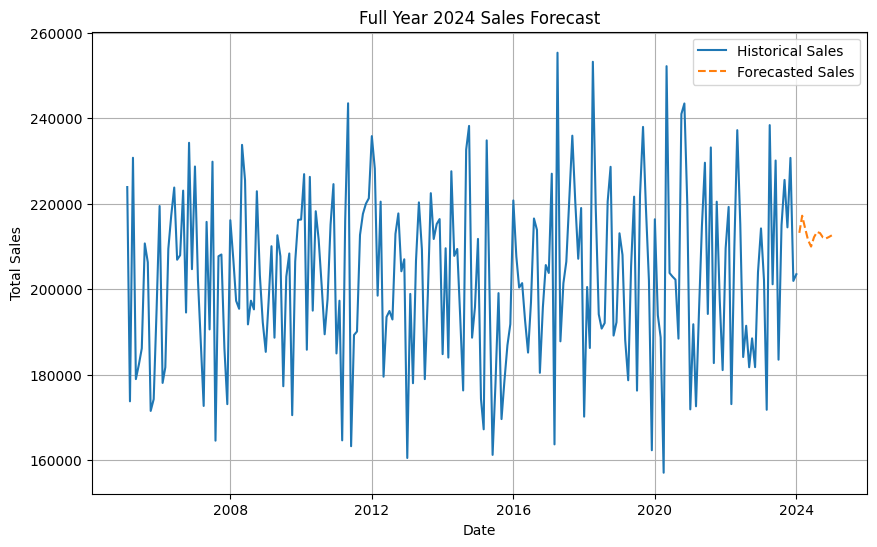

In [14]:
# Plot the historical sales and forecasted values for the next 12 months
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(forecast_12_months_dates, forecast_12_months, label='Forecasted Sales', linestyle='--')
plt.title('Full Year 2024 Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Evaluate the model by splitting data into training and testing
train_data = monthly_sales[:'2022-12-31']
test_data = monthly_sales['2023-01-01':]


In [16]:
# Retrain ARIMA model using only training data
model = ARIMA(train_data, order=(5, 1, 0))
model_fit = model.fit()


In [17]:
# Forecast on the test data
forecasted_values = model_fit.forecast(steps=len(test_data))


In [18]:
# Plot the actual vs forecasted sales
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Actual Sales')
plt.plot(test_data.index, forecasted_values, label='Forecasted Sales', linestyle='--')
plt.title('Actual vs Forecasted Sales for 2023')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Model evaluation metrics
mae = mean_absolute_error(test_data, forecasted_values)
mse = mean_squared_error(test_data, forecasted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - forecasted_values) / test_data)) * 100
accuracy = 100 - mape


In [20]:
# Display evaluation metrics
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Forecast Accuracy: {accuracy:.2f}%')

MAE: 18570.28
MSE: 501033482.07
RMSE: 22383.78
Forecast Accuracy: 91.39%


In [21]:
# Save the monthly sales to CSV for future reference
monthly_sales.to_csv('monthly_sales.csv', index=True)

In [22]:
import pickle
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Assuming the dataset and ARIMA model are already trained as shown earlier

# Fit the ARIMA model
model = ARIMA(monthly_sales, order=(5, 1, 0))
model_fit = model.fit()

# Save the model to a file
with open('arima_model.pkl', 'wb') as pkl_file:
    pickle.dump(model_fit, pkl_file)

print("Model saved as arima_model.pkl")


Model saved as arima_model.pkl
